## Modeling using Random Forest Classifier and SMOTE, and optimizing for Recall

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## week 3 imports
import missingno as msno     # msno.bar(titanic);  or msno.matrix(titanic);
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Linear and general modeling imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Feature Engineering
from sklearn.impute import SimpleImputer   # Imputation 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures   # Scale/transform/feature engineering

import patsy
# y, X = patsy.dmatrices(formula, data=diamonds, return_type='dataframe')

# GridSearch and Hyperparameter Tuning
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
########from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline

# Logistic and Classification metrics
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, classification_report

# K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler

# naive bayes imports
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# SVMs
from sklearn.svm import LinearSVC, SVC

# Decision Trees
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Import Bagging, Boosting, and Random Forests, and ExtraTrees (Extremely Randomized Trees)
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, AdaBoostClassifier, AdaBoostRegressor, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor

# NLP imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# nltk.download()  --> Download all, and then restart jupyter lab
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
import re

import json


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# !pip install imblearn

In [3]:
# imports SMOTE (oversampling) and undersampleing packages 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [4]:
# Loads in the data
df = pd.read_feather('../data/h201.feather')
df.head()

,DUID,PID,DUPERSID,PANEL,FAMID31,FAMID42,FAMID53,FAMID17,FAMIDYR,CPSFAMID,...,RXPTR17,RXOTH17,PERWT17F,FAMWT17F,FAMWT17C,SAQWT17F,DIABW17F,CSAQW17F,VARSTR,VARPSU
0,10001.0,101.0,10001101,21.0,A,A,A,A,A,A,...,2506.0,0.0,13494.959896,13651.501535,13651.501535,18363.716686,0.0,0.0,1021.0,1.0
1,10001.0,102.0,10001102,21.0,A,A,A,A,A,A,...,0.0,0.0,12031.802435,13651.501535,13651.501535,14279.941801,0.0,0.0,1021.0,1.0
2,10001.0,103.0,10001103,21.0,A,A,A,A,A,A,...,135.0,0.0,12308.918980,13651.501535,13651.501535,0.000000,0.0,0.0,1021.0,1.0
3,10001.0,104.0,10001104,21.0,A,A,A,A,A,A,...,0.0,0.0,12280.755977,13651.501535,13651.501535,0.000000,0.0,0.0,1021.0,1.0
4,10002.0,101.0,10002101,21.0,A,A,A,A,A,A,...,0.0,0.0,6596.640550,7113.635349,7113.635349,7427.265851,0.0,0.0,1077.0,1.0


In [5]:
# Loads in health status variables dataframe of variable descriptions
deps = pd.read_csv('../data/Health Status Variables.csv')
deps.head()

,VARIABLE,DESCRIPTION,SOURCE,Activate,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,IADLHP31,IADL Screener – RD 3/1,HE 1-3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADLHLP31,ADL Screener – RD 3/1,HE 4-6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AIDHLP31,Used Assistive Devices – RD 3/1,HE 7-8,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,WLKLIM31,Limitation in Physical Functioning – RD 3/1,HE 9-10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LFTDIF31,Difficulty Lifting 10 Pounds – RD 3/1,HE 11,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Subsets the health status variables for the ones that pertain to children
child_vars = list(deps['VARIABLE'][30:97])
# child_vars

In [7]:
# Creates a list of other variables we want to add
other_vars = ['AGELAST', 'SEX', 'RACEV2X', 'FAMINC17', 'ADHDADDX']

In [11]:
# Combines the child variables with additional other variables we want to add
child_vars = child_vars + other_vars

In [12]:
# Filters the age of children between 5-17
child_df = df.loc[(df['AGELAST'] <= 17) & (df['AGELAST'] >= 5), child_vars]
child_df

,CHPMED42,CHPMHB42,CHPMCN42,CHSERV42,CHSRHB42,CHSRCN42,CHLIMI42,CHLIHB42,CHLICO42,CHTHER42,...,AGELAST,SEX,RACEV2X,FAMINC17,ADHDADDX,AGELAST,SEX,RACEV2X,FAMINC17,ADHDADDX
2,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,...,17.0,1.0,1.0,125300.0,2.0,17.0,1.0,1.0,125300.0,2.0
3,1.0,1.0,1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,...,14.0,1.0,1.0,125300.0,2.0,14.0,1.0,1.0,125300.0,2.0
9,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,...,10.0,2.0,2.0,235653.0,2.0,10.0,2.0,2.0,235653.0,2.0
13,1.0,1.0,1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,...,12.0,2.0,1.0,18616.0,1.0,12.0,2.0,1.0,18616.0,1.0
14,1.0,1.0,1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,...,11.0,1.0,1.0,18616.0,1.0,11.0,1.0,1.0,18616.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31867,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,...,6.0,2.0,1.0,84000.0,2.0,6.0,2.0,1.0,84000.0,2.0
31870,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,...,9.0,2.0,1.0,650.0,2.0,9.0,2.0,1.0,650.0,2.0
31871,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,...,5.0,1.0,1.0,650.0,2.0,5.0,1.0,1.0,650.0,2.0
31878,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,...,13.0,2.0,1.0,268351.0,2.0,13.0,2.0,1.0,268351.0,2.0


In [13]:
# Checks the baseline/class balance of target variable
child_df['UNHAP42'].value_counts()

 0.0     4358
 1.0      879
 2.0      499
-1.0      195
 3.0      119
 4.0       65
-7.0       19
-8.0        8
-9.0        7
 99.0       6
Name: UNHAP42, dtype: int64

In [14]:
# filters the target variable to be between 0 and 4
hap_filter =(child_df['UNHAP42'] >= 0) & (child_df['UNHAP42'] <= 4)
child_df = child_df[hap_filter]

In [15]:
# Re-assigns the response variable into binary classes
child_df['UNHAP42'] = child_df['UNHAP42'].map({0:0, 1:1, 2:1, 3:1, 4:1})

<ipython-input-15-a1b61958f7cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  child_df['UNHAP42'] = child_df['UNHAP42'].map({0:0, 1:1, 2:1, 3:1, 4:1})


In [16]:
# Rechecks the balance/baseline of the target variable
child_df['UNHAP42'].value_counts(normalize=True)

0    0.736149
1    0.263851
Name: UNHAP42, dtype: float64

#### Modeling with Random Forest and SMOTE

Best params: (found when doing regular random forest grid search in other notebook)
* {'max_depth': 20,
* 'min_samples_leaf': 2,
* 'min_samples_split': 2,
* 'n_estimators': 180}

In [31]:
# Sets up X and y
X = child_df.drop(columns='UNHAP42')
y = child_df['UNHAP42']

In [32]:
X.shape

(5920, 76)

In [33]:
# TTS
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    random_state=42)

In [34]:
# Standard Scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [35]:
# Instantiates the random forest classifier with best params
rf = RandomForestClassifier(n_estimators=180, 
                            max_depth=20, 
                            min_samples_leaf=2,
                            min_samples_split=2,
                            random_state=42)

# rf = RandomForestClassifier(max_depth=10, 
#                             random_state=42)

In [36]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=180,
                       random_state=42)

In [37]:
# Evaluates the accuracy score
rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.9711711711711711, 0.8432432432432433)

**Instantiating SMOTE**

In [39]:
from collections import Counter
smote = SMOTE(sampling_strategy=0.4, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.4, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
X_train_res, y_train_res = under.fit_resample(X_train_res, y_train_res)
print('Resampled dataset shape %s' % Counter(y_train_res))
rf.fit(X_train_res, y_train_res)
rf.score(X_train_res, y_train_res), rf.score(X_test, y_test)

Resampled dataset shape Counter({0: 3267, 1: 1307})


(0.9709226060341059, 0.8398648648648649)

#### SMOTE in GridSearchCV

In [51]:
# Instantiates the pipeline for using SMOTE
pipe = Pipeline([
    ('over', SMOTE(random_state=42)), 
    ('under',RandomUnderSampler(random_state=42)), 
    ('rf', RandomForestClassifier(n_estimators=180, 
                                  max_depth=20, 
                                  min_samples_leaf=2,
                                  min_samples_split=2,
                                  random_state=42))
])

In [52]:
# sets the pipe params
pipe_params = {'over__sampling_strategy':[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               'under__sampling_strategy' : [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
              }

In [53]:
# Instantiates the gridsearch
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=3, 
                  verbose=1,
                  scoring='recall',
                  n_jobs=4)

In [54]:
# Fits the data to the gridsearch 
gs.fit(X_train, y_train)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


C:\Users\snchu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.59724572 0.64331432 0.69281046 0.72865106 0.76534199 0.7832601
 0.80885304        nan 0.60748027 0.65100444 0.68257153 0.72352504
 0.74997268 0.76960894        nan        nan 0.62453931 0.64587842
 0.68513127 0.714143   0.74998361        nan        nan        nan
 0.63648982 0.6578333  0.67574704 0.7090301         nan        nan
        nan        nan 0.63564168 0.65868144 0.68343279        nan
        nan        nan        nan        nan 0.64246617 0.67062977
        nan        nan        nan        nan        nan        nan
 0.64332525]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('over', SMOTE(random_state=42)),
                                       ('under',
                                        RandomUnderSampler(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(max_depth=20,
                                                               min_samples_leaf=2,
                                                               n_estimators=180,
                                                               random_state=42))]),
             n_jobs=4,
             param_grid={'over__sampling_strategy': [0.4, 0.5, 0.6, 0.7, 0.8,
                                                     0.9, 1.0],
                         'under__sampling_strategy': [0.4, 0.5, 0.6, 0.7, 0.8,
                                                      0.9, 1.0]},
             scoring='recall', verbose=1)

In [55]:
# Evaluates the gridsearch scores
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9658703071672355, 0.8153846153846154)

In [56]:
# Best gridsearch cross-validated score
gs.best_score_

0.8088530395435768

In [57]:
# Best gridsearch params for over sampling and undersampling strategy
gs.best_params_

{'over__sampling_strategy': 0.4, 'under__sampling_strategy': 1.0}

#### SMOTE in Pipeline

In [58]:
# Instantiates the pipeline for using SMOTE, with the best params determined
pipe = Pipeline([
    ('over', SMOTE(sampling_strategy=0.4, random_state=42)), 
    ('under',RandomUnderSampler(sampling_strategy=1.0, random_state=42)), 
    ('rf', RandomForestClassifier(n_estimators=307, 
                                  max_depth=10, 
                                  min_samples_leaf=2,
                                  min_samples_split=3,
                                  random_state=42))
])

In [59]:
# Fits the data to SMOTE (oversampe minority, undersample majority, random forest model)
pipe.fit(X_train, y_train)

Pipeline(steps=[('over', SMOTE(random_state=42, sampling_strategy=0.4)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=1.0)),
                ('rf',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                        min_samples_split=3, n_estimators=307,
                                        random_state=42))])

In [60]:
# sampling strategy = 0.8 for both over and under sampling
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.8813063063063064, 0.8222972972972973)

In [62]:
# Gets predictions from pipe model.
pipe_preds = pipe.predict(X_test)

# Recall Score 
recall_score(y_train, pipe.predict(X_train)), recall_score(y_test, pipe_preds) 

(0.8873720136518771, 0.8051282051282052)

In [66]:
# Finds the AUC score
roc_auc_score(y_test, pipe_preds)

0.816784286050341

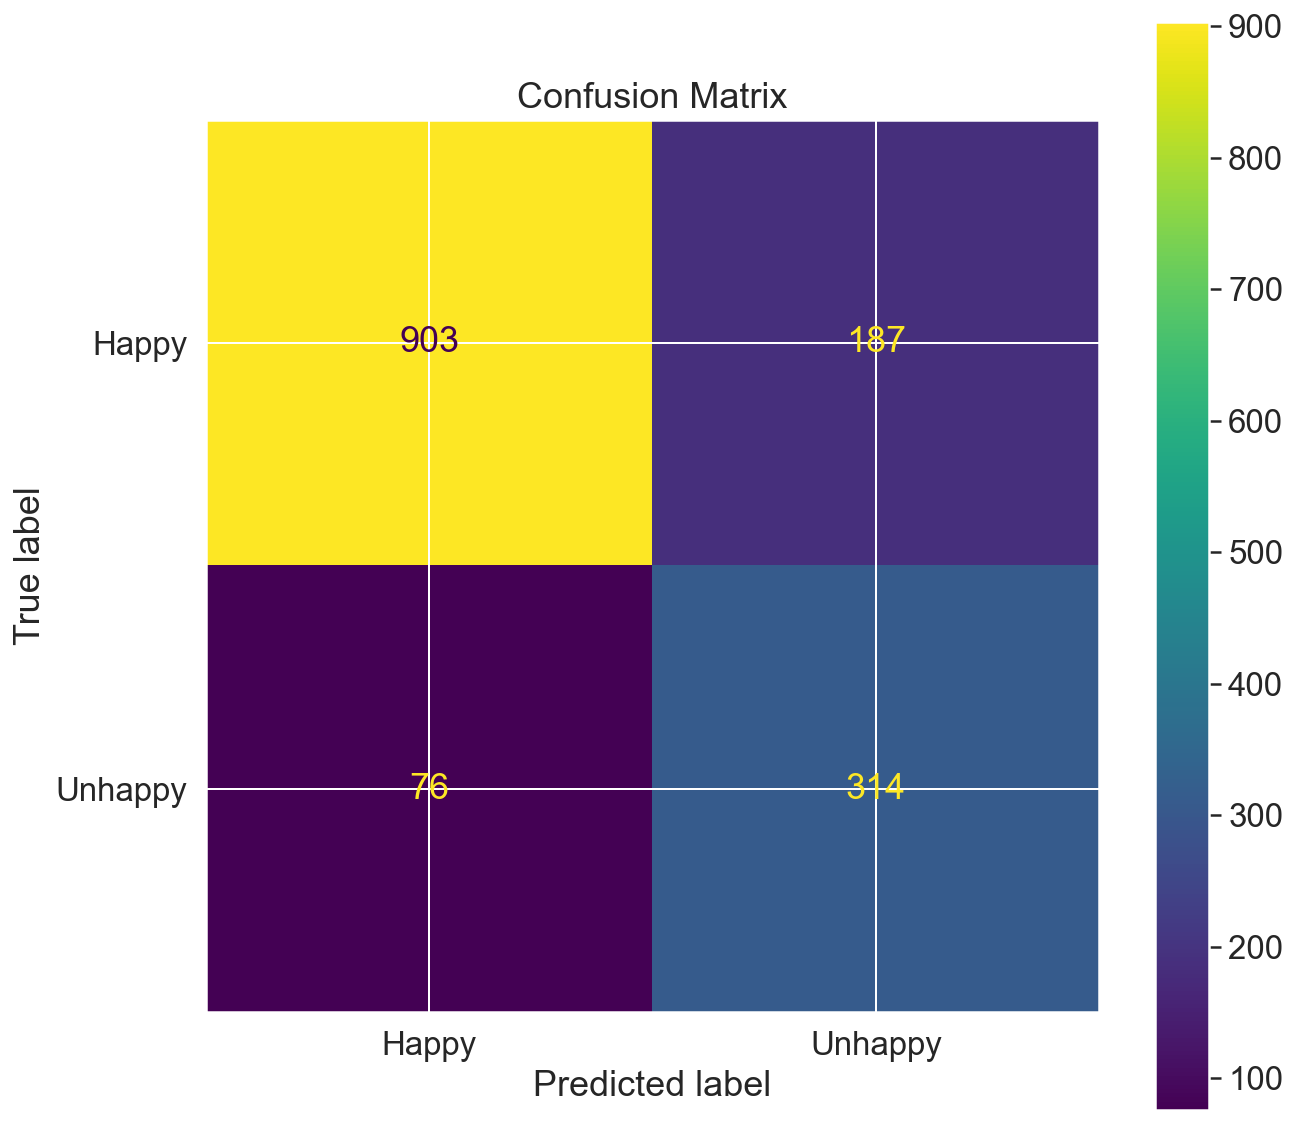

In [69]:
# Confusion matrix with pipe model predictions
sns.set(font_scale=1.5)
cm = confusion_matrix(y_test, pipe_preds)
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay(cm).plot(ax=ax)
plt.title('Confusion Matrix')
ax.set_xticklabels(['Happy', 'Unhappy'])
ax.set_yticklabels(['Happy', 'Unhappy']);

**Interpretation**: The confusion matrix no longer leans so heavily towards the false negatives after I adjusted the parameters to optimize for the recall score. This model has a much better recall score. 

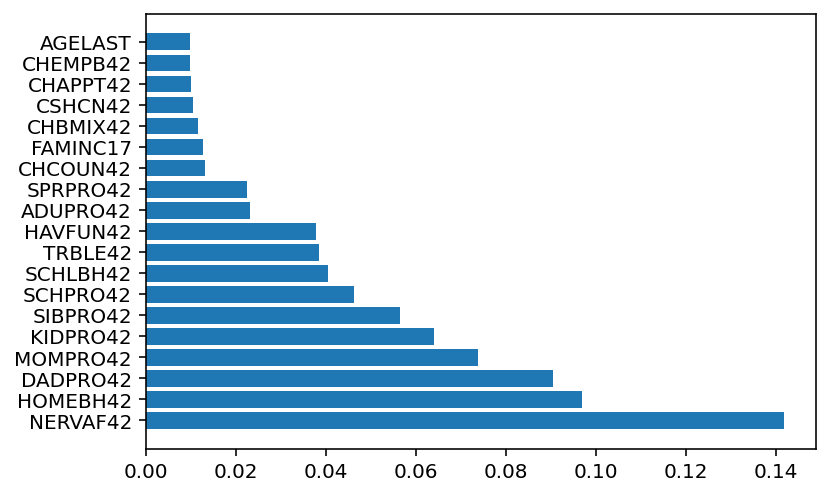

In [49]:
# The feature importances 
features = X.columns
feat_imp = pipe.named_steps['rf'].feature_importances_

importance_dict = pd.DataFrame({'feature_importance': feat_imp,
                                'features': features})
top = importance_dict.nlargest(20, columns=['feature_importance'])

plt.barh(top['features'], top['feature_importance']);
plt.savefig('../charts_graphs/rf_smote_recall_featImp.jpg')

**Interpretation**: There doesn't seem to be a large difference between the feature importances from this model compared to the base random forest model without the SMOTE implementation.  Nervousness is still the highest indicator or the most correlated factor with a child being unhappy. 